## obtain dataset

In [1]:
# http://dangminhthang.com/computer-vision/character-recognition-using-alexnet/
!wget https://github.com/minhthangdang/CharactersRecognition/blob/master/English.tar.gz?raw=true --output-document 'English.tar.gz'

--2022-10-12 21:31:45--  https://github.com/minhthangdang/CharactersRecognition/blob/master/English.tar.gz?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/minhthangdang/CharactersRecognition/raw/master/English.tar.gz [following]
--2022-10-12 21:31:46--  https://github.com/minhthangdang/CharactersRecognition/raw/master/English.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/minhthangdang/CharactersRecognition/master/English.tar.gz [following]
--2022-10-12 21:31:46--  https://raw.githubusercontent.com/minhthangdang/CharactersRecognition/master/English.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [2]:
!tar -xf English.tar.gz

In [3]:
# The dataset contain
# tree "English"
# English
#   ├──Fnt
#       ├── Sample001
#       │   ├── img001-00001.png
#       │   ├── img001-00002.png
#       │   ├── img001-00003.png
#       │   ├── ..........
#       ├── Sample002
#       │   ├── img002-00001.png
#       │   ├── img002-00002.png
#       │   ├── img002-00003.png
#       │   ├── ..........
#       ├── ......
#       │   ├── ..........
#       │   ├── ..........
#       │   ├── ..........

## Import library

In [4]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 22.2 MB/s 


In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
import keras.layers as layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Resizing
import visualkeras
import seaborn as sns
import string

## Read image dataset

- The Chars74k dataset contains the handwriting characters and the synthesised typing characters. The synthesised typing characters contains 0-9, A-Z, and a-z. The 0-9 A-Z dataset is going to be used in the project. The Chars74k 0-9 A-Z dataset contains 36576 images
> http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

In [6]:
# read image
# https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python
rootdir = "English"
# list of flatten nparray
image_matrix_list = []
# list of non flatten nparray
image_matrix_nparray_list = []
y_label_list = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        image_name = os.path.join(subdir, file)
        # Create list of X
        image_matrix_list.append(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).flatten())
        image_matrix_nparray_list.append(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE))
        # Create list of y_label
        m = re.search('/Sample.+?/', image_name)
        if m:
          found = m.group(0)
          found = found.strip("/")
          found = re.findall(r'\d+', found)[0]
        y_label_list.append(int(found))

In [7]:
# Read image
# # Open the subdir
# # Loop the subdir
# # In every subdir loop image
# rootdir = "English/Fnt"
# subdir_list = os.listdir(rootdir)
# # list of flatten nparray
# image_matrix_list = []
# # list of non flatten nparray
# image_matrix_nparray_list = []
# y_label_list
# for index, subdir in enumerate(subdir_list):
#   for image_name in os.listdir("%s/%s" % (rootdir, subdir)):
#     image_name = "%s/%s/%s" % (rootdir, subdir, image_name)
#     # Create list of X
#     image_matrix_list.append(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE).flatten())
#     image_matrix_nparray_list.append(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE))
#     # Create list of y_label
#     m = re.search('/Sample.+?/', image_name)
#     if m:
#       found = m.group(0)
#       found = found.strip("/")
#       found = re.findall(r'\d+', found)[0]
#     y_label_list.append(int(found))

## Save image to csv

In [8]:
# # nparray to csv
# X = np.array(image_matrix_list, dtype=np.float32)
# np.savetxt("X.csv", X, delimiter=",")
# y_label = np.array(y_label_list, dtype=np.uint8)
# np.savetxt("y_label.csv", y_label, delimiter=",")

In [9]:
# # DataFrame to CSV
# # Create y_label column
# y_label_df = pd.DataFrame(y_label_list, columns=["y_label"])
# # Create image matrix column
# image_matrix_df = pd.DataFrame()
# for i in range(0, len(image_matrix_list)):
#   row = pd.DataFrame(image_matrix_list[i]).transpose()
#   image_matrix_df = image_matrix_df.append(row, ignore_index = True)
# # Convert dataframe to csv
# df_to_csv = image_matrix_df.copy()
# df_to_csv["y_label"] = y_label_list
# df_to_csv.to_csv("typing_character_number.csv", sep='\t')

## Data processing

- Convert to np array
- Create the train dataset and the test dataset
- Normalizing the dataset
  - The image value is from 0 to 255
  - We can normalize data by changing the range from (0 to 255) to (0 to 1)
  - The reason we normalize the dataset is that when color change we do not have care about it
- Reshape image in order to apply CNN
  - Reshape image in order to apply CNN
  - The input image shape of TensorFlow has to be (number_of_image, image_size, image_size, color_channel)
  - We have to convert the image shape (number_of_image, image_size, image_size) to (number_of_image, image_size, image_size, color_channel)
  - We have to add the color channel to the dimension
  - It is the gray scale image, so the coler channel is 1
  - If it were in color, the color channel would be 3
- One hot encode
  - We also know that there are 36 classes and that classes are represented as unique integers
  - We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 36 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function

> Reference

> https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

- Convert list of np array to np array of np array

In [10]:
# Convert list of nparray to nparray of nparray
X = np.array(image_matrix_nparray_list, dtype=np.float32)
X.shape

(36576, 128, 128)

In [11]:
# Create nparray of y_label
y_label = np.array(y_label_list, dtype=np.uint8)
y_label.shape

(36576,)

- Create the train dataset and the test dataset

In [12]:
# Create the train dataset and the test dataset
(X_train, X_test, y_train, y_test) = train_test_split(X, y_label, test_size=0.2, shuffle=True)
print("X_train %s \ny_train %s \nX_test %s \ny_test %s" % (X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train (29260, 128, 128) 
y_train (29260,) 
X_test (7316, 128, 128) 
y_test (7316,)


- Look at dataset

In [13]:
print("The training set contains %s images and the testing set contains %s images" % (X_train.shape[0], X_test.shape[0]))
print("The training input vector is of the dimension %s X %s X %s" % (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print("The training output vector is of the dimension %s X 1" % (y_train.shape[0]))
print("Each individual input vector is of the dimension %s X %s" % (X_train.shape[1], X_train.shape[2]))
print("Each individual output vector is of the dimension 1")

The training set contains 29260 images and the testing set contains 7316 images
The training input vector is of the dimension 29260 X 128 X 128
The training output vector is of the dimension 29260 X 1
Each individual input vector is of the dimension 128 X 128
Each individual output vector is of the dimension 1


- Check the image

class label  3


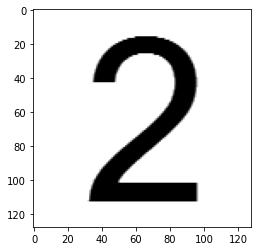

In [14]:
print("class label ", y_train[0])
plt.imshow(X_train[0], cmap = plt.get_cmap("gray"))
plt.show()

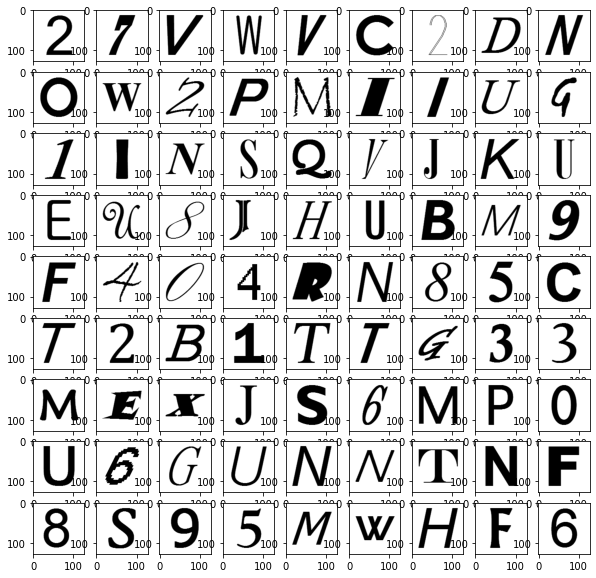

In [15]:
rows, cols = 9, 9

plt.figure(figsize=(10, 10))

for i in range(rows * cols):
  plt.subplot(cols, rows, i + 1)
  plt.imshow(X_train[i], cmap = plt.get_cmap("gray"))

- Check pixel value

In [16]:
X_train[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

- Normalizing the dataset
  - The image value is from 0 to 255
  - We can normalize data by changing the range from (0 to 255) to (0 to 1)
  - The reason we normalize the dataset is that when color change we do not have care about it

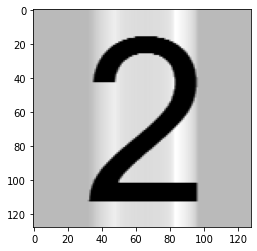

In [17]:
# We can normalize it using Keras library
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)
plt.imshow(X_train[0], cmap = plt.get_cmap("gray"))

# We can manually normalize it
# convert from integers to floats
# X_train = X_train.astype('float32')
# X_train = X_train.astype('float32')
# X_train = X_train / 255
# X_test = X_test / 255
# plt.imshow(X_train[0], cmap = plt.get_cmap("gray"))

In [18]:
# The value is from 0 to 1
X_train[0]

array([[0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835],
       [0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835],
       [0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835],
       ...,
       [0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835],
       [0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835],
       [0.08838835, 0.08838835, 0.08838835, ..., 0.08838835, 0.08838835,
        0.08838835]], dtype=float32)

- Reshape image in order to apply CNN

In [19]:
# Reshape image in order to apply CNN
# The input image shape of TensorFlow has to be (number_of_image, image_size, image_size, color_channel)
# We have to convert the image shape (number_of_image, image_size, image_size) to (number_of_image, image_size, image_size, color_channel)
# We have to add the color channel to the dimension
# It is the gray scale image, so the coler channel is 1
# If it were in color, the color channel would be 3
image_size = 128
X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 1)
X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 1)

- One hot encode
  - We also know that there are 36 classes and that classes are represented as unique integers
  - We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 36 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function 

In [20]:
print(y_train[0])
print(y_train.shape)

3
(29260,)


In [21]:
print(y_test[0])
print(y_test.shape)

27
(7316,)


In [22]:
# One Hot Encode y label
# Convert
# 5
# To
# [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [23]:
print(y_train[0])
print(y_train.shape)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(29260, 37)


In [24]:
print(y_test[0])
print(y_test.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(7316, 37)


## Building up model

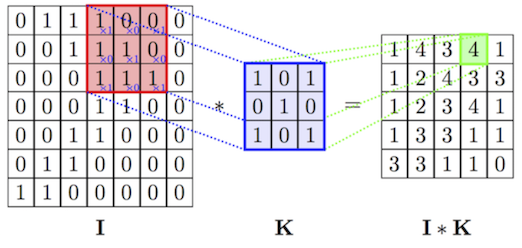

> Source

> https://www.kaggle.com/code/curiousprogrammer/lenet-5-cnn-with-keras-99-48/notebook

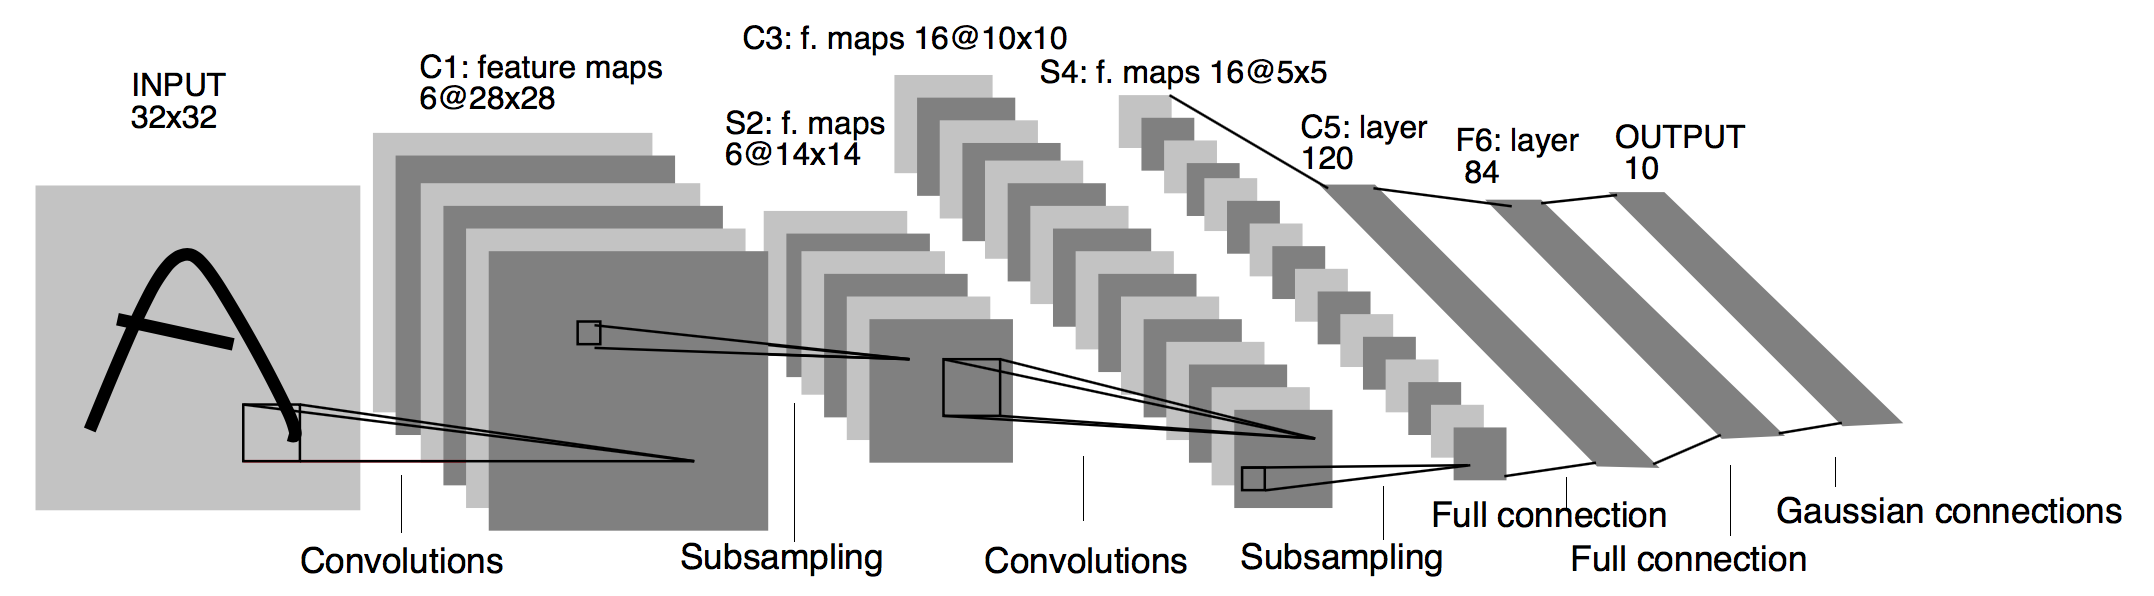

> Source

> https://towardsdatascience.com/review-of-lenet-5-how-to-design-the-architecture-of-cnn-8ee92ff760ac

Building up the LeNet CNN model, which is among the first published CNNs to capture wide attention for its performance on computer vision tasks. The model was introduced by Yann LeCun, then a researcher at AT&T Bell Labs, for the purpose of recognizing handwritten digits in images.
- The input image size in the original paper is 32 X 32, so the model is going to resize the image size to be 32 X 32
- The original paper does not use ReLUs as the activation function, but it is working better, so the model is going to use the ReLUs as the activation function
- In the first convolution, 
  - the number of filter is 6 and 
  - the filter size is 5 X 5 
  - the filter move 1 pixel every time
  - So, the C1 feature map contains 6 layers and the size of every layer is 28 X 28, matrix size of 32 X matrix of size 5 = matrix of size 28, 32 - 5 + 1 = 28, ((Input-filter size)/ stride)+1
- In the first subsampling, 
  - the AveragePooling is implemented 
    - The pool_size=(2, 2), strides=(2, 2)
    - so, the filter matrix is 2 X 2 and it move 2 pixel every time
  - So, the S2 feature map contains 6 layers, it is as same as C1 and it is not changed, and the size of every layer is 14 X 14, it is the half size of 28 in C1
- In the second convolution, 
  - the number of filter is 16 and 
  - the filter size is 5 X 5
  - the filter move 1 pixel every time
  - So, the C3 feature map contains 16 layers and the size of every layer is 10 X 10, matrix size of 14 X matrix of size 5 = matrix of size 10, 14 - 5 + 1 = 10
- In the second subsampling, 
  - the AveragePooling is implemented 
    - The pool_size=(2, 2), strides=(2, 2)
    - so, the filter matrix is 2 X 2 and it move 2 pixel every time
  - So, the S4 feature map contains 16 layers, it is as same as C3 and it is not changed, and the size of every layer is 5 X 5, it is the half size of 5 in C3
- Next, the full connection is implemented. LeNet’s dense block has three fully connected layers 
  - The first dense unit is 120, the second unit is 84, and the third dense is the number class, which is 36 classes, A - Z, 0 - 9

> Reference

> http://d2l.ai/chapter_convolutional-neural-networks/lenet.html

> https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/#

In [25]:
image_shape = (X_train.shape[1], X_train.shape[2], 1)
number_of_class = y_train.shape[1]

model = keras.Sequential()
model.add(Resizing(32,32, interpolation='bilinear', input_shape=image_shape))
model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=number_of_class, activation = 'softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0

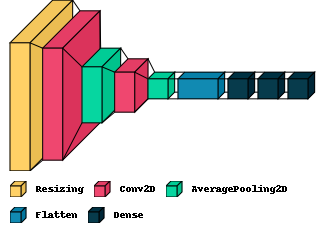

In [27]:
visualkeras.layered_view(model, legend=True)

In [28]:
# Compile the model
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
641/641 [==============================] - 14s 9ms/step - loss: 1.3350 - accuracy: 0.6570 - val_loss: 0.6133 - val_accuracy: 0.8435
Epoch 2/100
641/641 [==============================] - 4s 6ms/step - loss: 0.4970 - accuracy: 0.8710 - val_loss: 0.4457 - val_accuracy: 0.8787
Epoch 3/100
641/641 [==============================] - 3s 5ms/step - loss: 0.3816 - accuracy: 0.8941 - val_loss: 0.3702 - val_accuracy: 0.9001
Epoch 4/100
641/641 [==============================] - 3s 5ms/step - loss: 0.3112 - accuracy: 0.9120 - val_loss: 0.3387 - val_accuracy: 0.9010
Epoch 5/100
641/641 [==============================] - 3s 5ms/step - loss: 0.2720 - accuracy: 0.9215 - val_loss: 0.3011 - val_accuracy: 0.9159
Epoch 6/100
641/641 [==============================] - 4s 6ms/step - loss: 0.2346 - accuracy: 0.9304 - val_loss: 0.2593 - val_accuracy: 0.9225
Epoch 7/100
641/641 [==============================] - 3s 5ms/step - loss: 0.2096 - accuracy: 0.9364 - val_loss: 0.2692 - val_accuracy: 0.919

## Look at the model

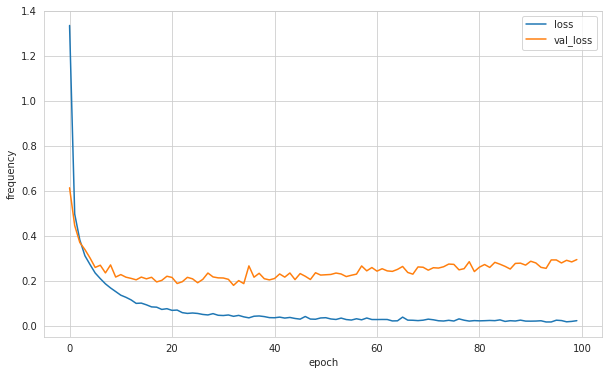

In [30]:
# Plot style and size
sns.set_style("whitegrid")
plt.subplots(figsize=(10,6))
# x axis and y axis
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epoch = list(range(len(loss)))

sns.lineplot(x = epoch, y = loss, label="loss")
sns.lineplot(x = epoch, y = val_loss, label="val_loss").set(xlabel='epoch', ylabel='frequency')

plt.show()

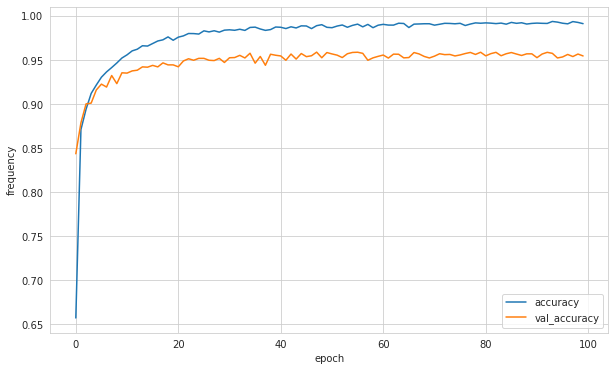

In [31]:
# Plot style and size
sns.set_style("whitegrid")
plt.subplots(figsize=(10,6))
# x axis and y axis
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epoch = list(range(len(accuracy)))

sns.lineplot(x = epoch, y = accuracy, label="accuracy")
sns.lineplot(x = epoch, y = val_accuracy, label="val_accuracy").set(xlabel='epoch', ylabel='frequency')

plt.show()

229/229 [==============================] - 1s 3ms/step


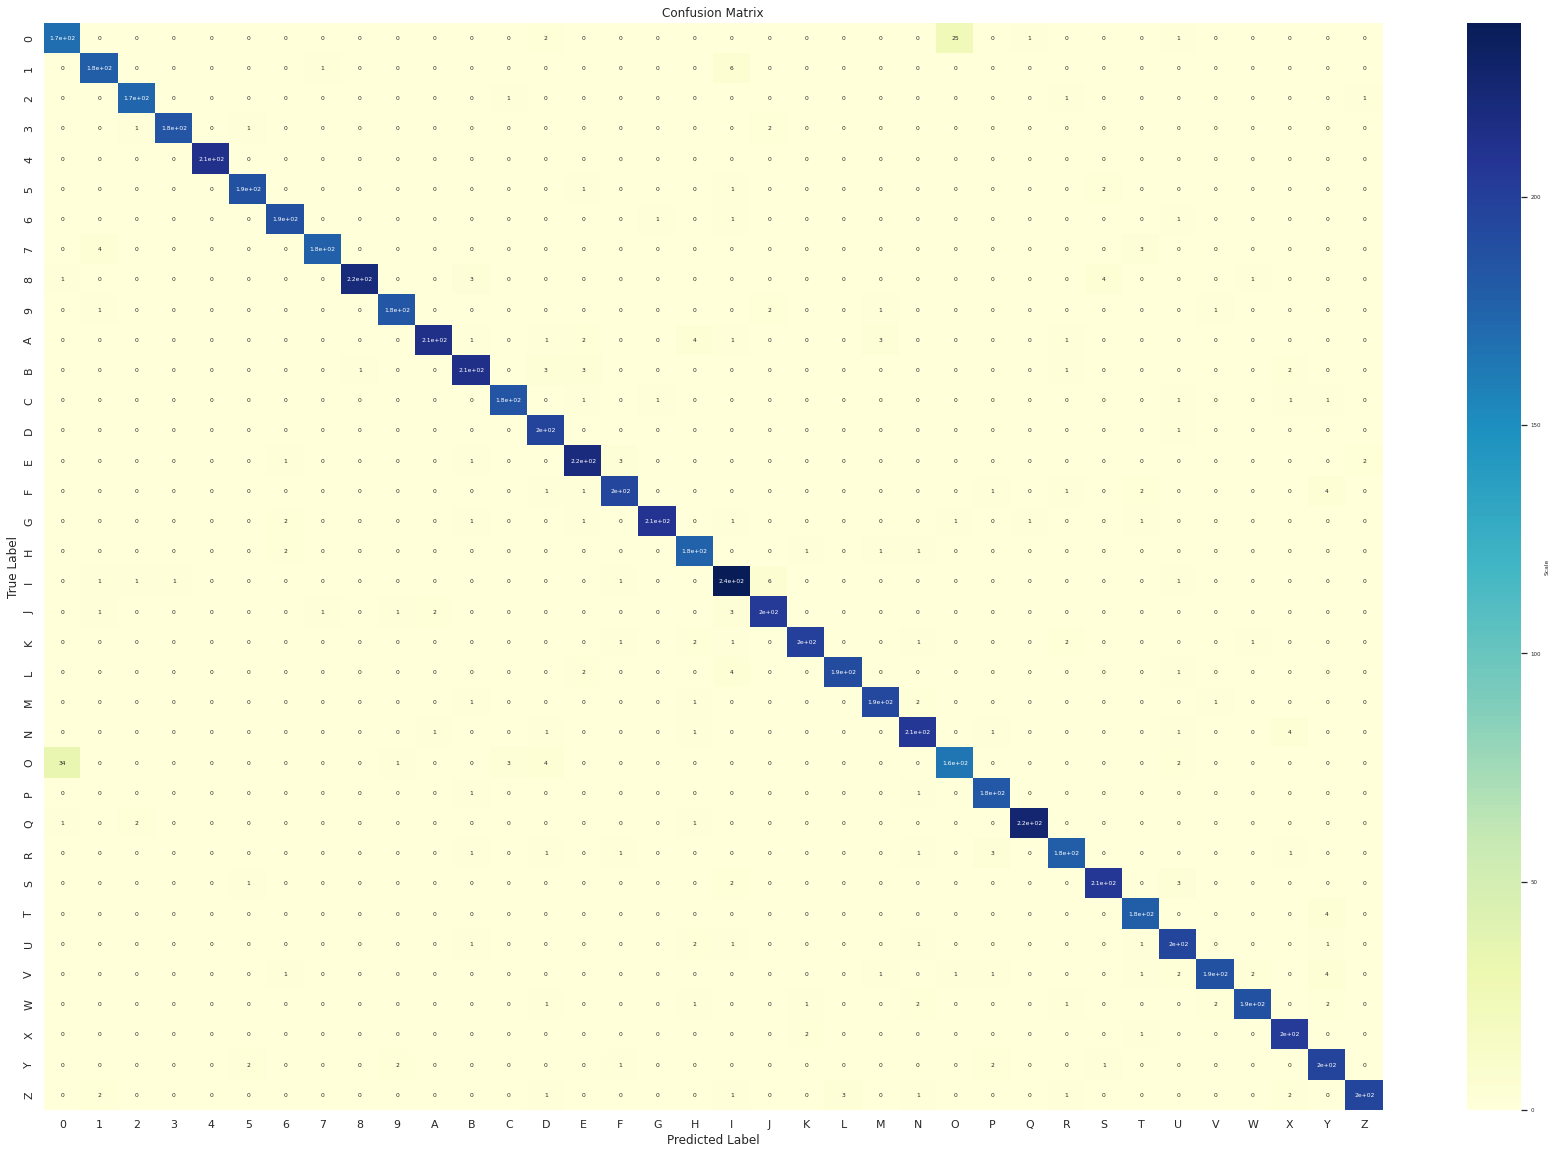

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_data = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
# Plot confusion matrix
# https://onestopdataanalysis.com/confusion-matrix-python/
def plot_confusion_matrix(data, labels):
  """Plot confusion matrix using heatmap.

  Args:
      data (list of list): List of lists with confusion matrix data.
      labels (list): Labels which will be plotted across x and y axis.

  """
  sns.set(color_codes=True)
  plt.figure(1, figsize=(30, 20))

  plt.title("Confusion Matrix")

  sns.set(font_scale=0.5)
  ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})

  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  ax.set(ylabel="True Label", xlabel="Predicted Label")

  plt.show()

labels = list(range(0, 10)) + list(string.ascii_uppercase)

plot_confusion_matrix(confusion_matrix_data, labels)



## Saving the model

In [37]:
# Saving the model
model.save("letter_number_cnn.h5")

## Predict test dataset

In [38]:
from keras.models import load_model
classifier = load_model("letter_number_cnn.h5")

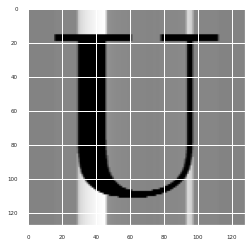

In [39]:
plt.imshow(X_test[90].reshape(image_size, image_size), cmap=plt.get_cmap("gray"))

In [40]:
prediction = classifier.predict(X_test)

229/229 [==============================] - 1s 2ms/step


In [41]:
labels = list(range(0, 10)) + list(string.ascii_uppercase)

In [42]:
print(labels[np.argmax(prediction[90]) - 1])

U


In [43]:
print(labels[np.argmax(y_test[90]) - 1])

U


## Predict import image

In [81]:
from keras.models import load_model
classifier = load_model("letter_number_cnn.h5")

In [82]:
import cv2
create_image = cv2.imread("letter.png")

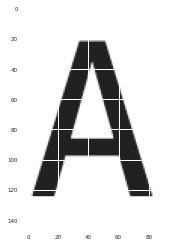

In [83]:
plt.imshow(create_image)

In [84]:
create_image.shape

(144, 92, 3)

In [85]:
convert_gray = cv2.cvtColor(create_image, cv2.COLOR_BGR2GRAY)

In [86]:
convert_gray.shape

(144, 92)

In [87]:
reshape_image = cv2.resize(convert_gray, (image_size, image_size), interpolation=cv2.INTER_AREA)

In [88]:
reshape_image.shape

(128, 128)

In [89]:
reshape_image = tf.keras.utils.normalize(reshape_image, axis=1)
reshape_image_1 = np.array(reshape_image).reshape(-1, image_size, image_size, 1)

In [90]:
prediction = classifier.predict(reshape_image_1)
print(prediction)

1/1 [==============================] - 0s 69ms/step
[[0.0000000e+00 4.1289386e-36 4.2581828e-22 5.2172997e-35 0.0000000e+00
  1.7005323e-17 2.5525421e-14 0.0000000e+00 4.3903511e-23 9.7431175e-26
  6.7114591e-32 7.7688491e-01 4.2173872e-34 4.3246372e-26 5.5559808e-16
  1.4720495e-29 0.0000000e+00 1.4411700e-18 5.4311011e-11 1.2552442e-12
  2.2311512e-01 2.7570762e-19 7.1839839e-12 8.0544073e-18 4.8335431e-19
  1.5430421e-21 7.0300455e-14 1.2352657e-22 3.2760077e-19 2.5044761e-17
  3.5969461e-20 5.6646551e-16 8.5429438e-28 3.0780656e-26 1.2563314e-16
  3.4323556e-23 6.8060713e-12]]


In [91]:
labels = list(range(0, 10)) + list(string.ascii_uppercase)

In [92]:
print(labels[np.argmax(prediction[0]) - 1])

A
